In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

column_names = [
    "white-king-file","white-king-rank","white-rook-file","white-rook-rank","black-king-file","black-king-rank","white-depth-of-win"
]
df = pd.read_csv("krkopt.data",header=None,names=column_names)
mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
for col in ["white-king-file","white-rook-file","black-king-file"]:
    df[col] = df[col].map(mapping)

#draw, zero, one, two, ..., sixteen - zmapowac
mapping2 = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9,
    'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13,
    'fourteen': 14, 'fifteen': 15, 'sixteen': 16, 'draw': -1}
df["white-depth-of-win"] = df["white-depth-of-win"].map(mapping2)
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,1,1,2,3,3,2,-1
1,1,1,3,1,3,2,-1
2,1,1,3,1,4,1,-1
3,1,1,3,1,4,2,-1
4,1,1,3,2,3,1,-1


In [3]:
#METRYKI: euklides, manhattan, czebyszew - szachowa - d(x,y) = max k = 1,...n abs(xk-yk)
wkf = df["white-king-file"]
wkr = df["white-king-rank"]
bkf = df["black-king-file"]
bkr = df["black-king-rank"]
dx = (wkf - bkf).abs()
dy = (wkr - bkr).abs()
df["dist_e"] = np.sqrt(dx**2 + dy**2)
df["dist_m"] = dx + dy
df["dist_c"] = np.maximum(dx, dy)
df["black-edge-dist"] = df.apply(
    lambda row: int(min(
        row["black-king-file"] - 1,
        8 - row["black-king-file"],
        row["black-king-rank"] - 1,
        8 - row["black-king-rank"]
    )),
    axis=1
)
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win,dist_e,dist_m,dist_c,black-edge-dist
0,1,1,2,3,3,2,-1,2.236068,3,2,1
1,1,1,3,1,3,2,-1,2.236068,3,2,1
2,1,1,3,1,4,1,-1,3.000000,3,3,0
3,1,1,3,1,4,2,-1,3.162278,4,3,1
4,1,1,3,2,3,1,-1,2.000000,2,2,0


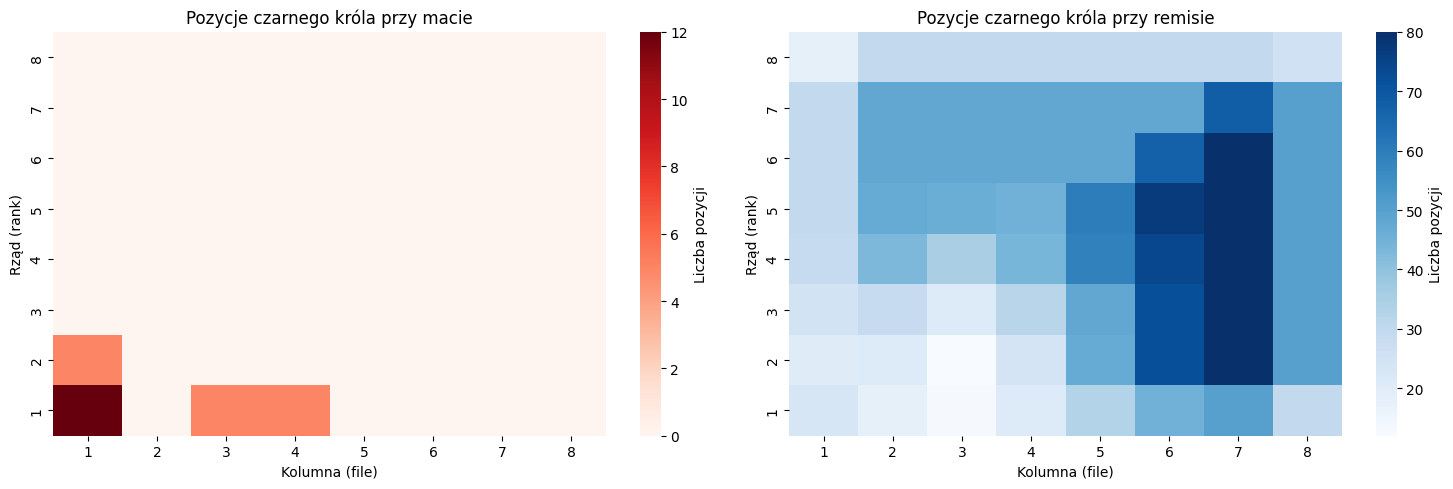

In [78]:
mate = df[df["white-depth-of-win"] == 0]
draw = df[df["white-depth-of-win"] == -1]

matemap = pd.crosstab(mate["black-king-rank"], mate["black-king-file"]).reindex(index=range(1,9), columns=range(1,9), fill_value=0)
drawmap = pd.crosstab(draw["black-king-rank"], draw["black-king-file"]).reindex(index=range(1,9), columns=range(1,9), fill_value=0)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(matemap.iloc[::-1], cmap="Reds", cbar_kws={'label': 'Liczba pozycji'})
plt.title("Pozycje czarnego króla przy macie")
plt.xlabel("Kolumna (file)")
plt.ylabel("Rząd (rank)")

plt.subplot(1,2,2)
sns.heatmap(drawmap.iloc[::-1], cmap="Blues", cbar_kws={'label': 'Liczba pozycji'})
plt.title("Pozycje czarnego króla przy remisie")
plt.xlabel("Kolumna (file)")
plt.ylabel("Rząd (rank)")

plt.tight_layout()
plt.show()


A1: (Pamiętając o symetrii) Przy macie czarny król zawsze znajduje się w rogu planszy, bądź jego bezpośrednim sąsiedztwie w obrębie wiersza // kolumny (wyjscie poza ten obszar blokuje wieza// król przeciwnika)
Przy remisie znajduje się on w obrebie kolumn f/g, nie przy krawędzi.


Euklidesowa: Pearson=0.2907, Spearman=0.2428
Manhattan: Pearson=0.2967, Spearman=0.2566
Czebyszewa: Pearson=0.2660, Spearman=0.2127


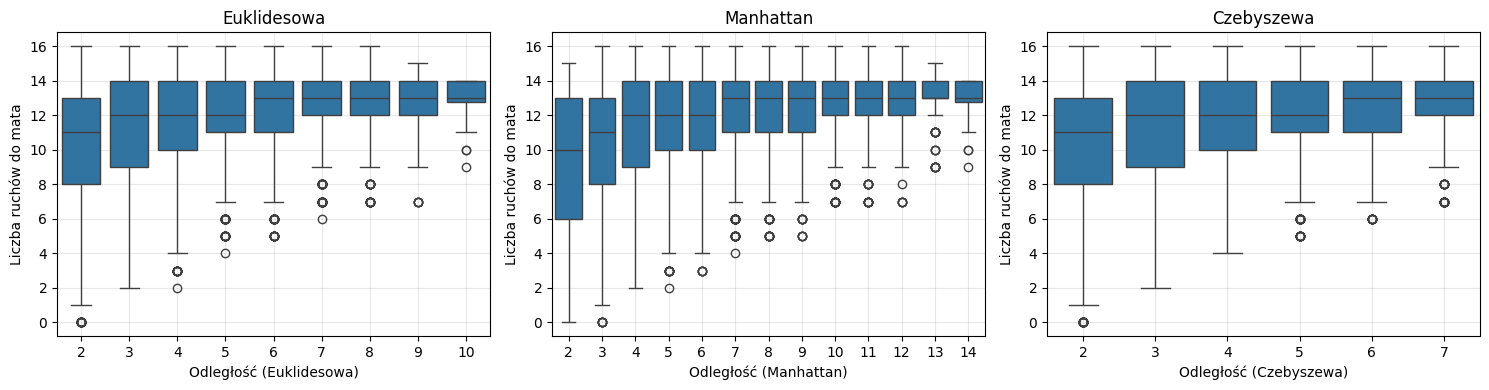

In [79]:
from scipy.stats import pearsonr, spearmanr

df_wins = df[df["white-depth-of-win"] != -1]
metrics = ['dist_e', 'dist_m', 'dist_c']
metric_names = ['Euklidesowa', 'Manhattan', 'Czebyszewa']

from scipy.stats import pearsonr, spearmanr
for metric, name in zip(metrics, metric_names):
    pearson = pearsonr(df_wins[metric], df_wins['white-depth-of-win'])[0]
    spearman = spearmanr(df_wins[metric], df_wins['white-depth-of-win'])[0]
    print(f"{name}: Pearson={pearson:.4f}, Spearman={spearman:.4f}")

plt.figure(figsize=(15,4))
for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(1,3,i+1)
    
    sns.boxplot(
        x=df_wins[metric].round().astype(int),
        y=df_wins['white-depth-of-win'],
    )
    
    plt.xlabel(f'Odległość ({name})')
    plt.ylabel('Liczba ruchów do mata')
    plt.title(name)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Metryki Euklidesowa i Manhattan mają podobne współczynniki korelacji z liczbą ruchów potrzebną do zakończenia gry, wyższe niż Czebyszewa. Patrząc jednak po ich definicjach to Czebyszew ("szachowa") ma największy sens - pokazuje ona minimalną ilość ruchów potrzebną królowi na przejście z punktu A do B (uwzględniając, że król może chodzić na ukos)
 

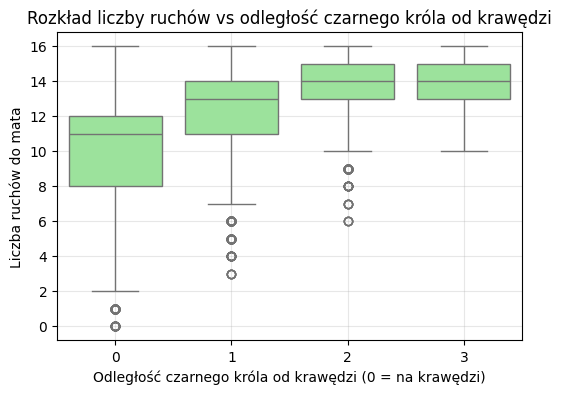

In [80]:
df2 = df[df["white-depth-of-win"] != -1]

plt.figure(figsize=(6,4))
sns.boxplot(
    x='black-edge-dist',
    y='white-depth-of-win',
    data=df2,
    color='lightgreen'
)
plt.xlabel("Odległość czarnego króla od krawędzi (0 = na krawędzi)")
plt.ylabel("Liczba ruchów do mata")
plt.title("Rozkład liczby ruchów vs odległość czarnego króla od krawędzi")
plt.grid(True, alpha=0.3)
plt.show()


Tak, informacja o odległości czarnego króla od krawędzi może być przydatna. Z wykresu widać, że im dalej od krawędzi tym dłużej średnio zajmuje zmatowanie (trzeba zepchnąć króla do rogu // na krawędź)

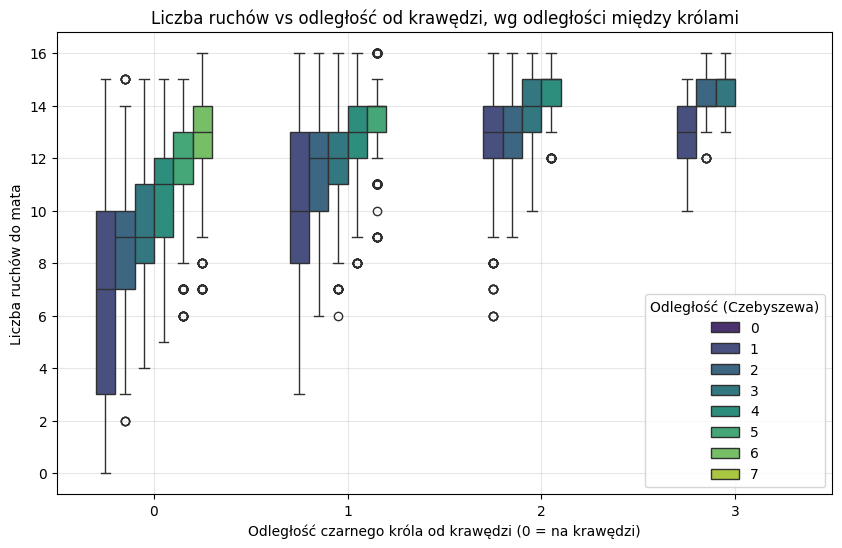

In [81]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='black-edge-dist', 
    y='white-depth-of-win', 
    hue=pd.cut(df2['dist_c'], bins=[0,1,2,3,4,5,6,7,8], labels=['0','1','2','3','4','5','6','7']),
    data=df2,
    palette='viridis'
)

plt.xlabel("Odległość czarnego króla od krawędzi (0 = na krawędzi)")
plt.ylabel("Liczba ruchów do mata")
plt.title("Liczba ruchów vs odległość od krawędzi, wg odległości między królami")
plt.legend(title="Odległość (Czebyszewa)")
plt.grid(True, alpha=0.3)
plt.show()


Uzupełnienie poprzedniego informacją o odległości między królami pomaga. Z wykresu widać, że nawet jeżeli czarny król jest blisko krawędzi (0/1) to jeżeli dystans między królami jest duży to nadal potrzeba dużo ruchów do mata. 